# 21L-5231 Qasim Naveed
# 21L-1864 Khawaja Afnan Asif
# 21L-1775 Rameez
# 21l-5175 Taha Sheikh

# DATA LOADING AND PREPROCESSING

For data we chose Kaggle dataset of Women Clothing E-Commerce Reviews for training the model for doing sentiment analysis on reviews. For preprocessing we cleaned the text such that all the alphanumeric words which are note english words are removed as well as numbers. Moreover we removed the stopwords like and, or, but as they do not contribute in the sentiment analysis. Also, we lematized all the words to handle OOV situation as much as we can.

### **Importing The required libraries**

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import re
import string
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import pickle

import warnings
warnings.simplefilter('ignore')

# DATA CLEANING

In [77]:
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

URL_DATA  = r'Womens Clothing E-Commerce Reviews.csv'
CLEANED_DATA_PATH = r'clean.csv'


def read_data(path: str) -> pd.DataFrame:
    try:
        df = pd.read_csv(path, header=0, index_col=0)
        return df
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return pd.DataFrame()


def clean_text(words: str) -> str:
    words = re.sub("[^a-zA-Z]", " ", words)
    text = words.lower().split()
    return " ".join(text)


def remove_numbers(text: str) -> str:
    new_text = []
    for word in text.split():
        if not re.search('\\d', word):
            new_text.append(word)
    return ' '.join(new_text)


def remove_stopwords(review: str) -> str:
    stop_words = stopwords.words('english')
    clothes = ['dress', 'color', 'wear', 'top', 'sweater', 'material', 'shirt',
           'jeans', 'pant', 'skirt', 'order', 'white', 'black', 'fabric',
           'blouse', 'sleeve', 'even', 'jacket']
    text = [word.lower() for word in review.split() if word.lower() not in
            stop_words and word.lower() not in clothes]
    return " ".join(text)


def get_lemmatize(text: str) -> str:
    lem = WordNetLemmatizer()
    lem_text = [lem.lemmatize(word) for word in text.split()]
    return " ".join(lem_text)


def preprocess_data(data: str) -> str:
    data['Review'] = data['Review'].astype(str)
    data['Review'] = data['Review'].apply(clean_text)
    data['Review'] = data['Review'].apply(remove_numbers)
    data['Review'] = data['Review'].apply(remove_stopwords)
    data['Review'] = data['Review'].apply(get_lemmatize)
    return data


if __name__ == '__main__':
    data = read_data(URL_DATA)
    dataset = preprocess_data(data)
    if not dataset.empty:
        print(dataset.shape)
        print(dataset.head(5))
        dataset = dataset[['Review', 'Sentiment']]
        dataset.to_csv(CLEANED_DATA_PATH, encoding='utf-8')

[nltk_data] Downloading package stopwords to C:\Users\Qasim
[nltk_data]     Naveed\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Qasim
[nltk_data]     Naveed\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


(23486, 10)
   Clothing ID  Age                    Title  \
0          767   33                      NaN   
1         1080   34                      NaN   
2         1077   60  Some major design flaws   
3         1049   50         My favorite buy!   
4          847   47         Flattering shirt   

                                              Review  Rating  Sentiment  \
0        absolutely wonderful silky sexy comfortable       4          1   
1  love sooo pretty happened find store glad bc n...       5          1   
2  high hope really wanted work initially ordered...       3          0   
3  love love love jumpsuit fun flirty fabulous ev...       5          1   
4  flattering due adjustable front tie perfect le...       5          1   

   Positive Feedback Count   Division Name Department Name Class Name  
0                        0       Initmates        Intimate  Intimates  
1                        4         General         Dresses    Dresses  
2                        0      

# Modeling

For the process of Modeling we tried and tested different embeddings and architectures. We tried GloVe embeddings with Bidirectional LSTM and BOW + TF-IDF Embeddings with Naive Bayes classifier.

# Glove Embeddings With Bidirectional LSTM

The Bidirectional LSTMs are an extension of traditional LSTMs and used to ensure that information is passed backward and forward. 
They may be used on sequence classification problems.
The idea of Bidirectional Recurrent Neural Networks (RNNs) is  involves duplicating the first recurrent layer in the network so that there are now two layers side-by-side. Next providing  the input sequence as input to the first layer and providing a reversed copy of the input sequence to the second.

We download the pre-trained word embeddings.

Next we extract them into a temporary folder:

In [78]:
with zipfile.ZipFile('glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('/tmp/glove')

### **Data preparation**

In [79]:
df = pd.read_csv('clean.csv', header=0,index_col=0)
df.head()

,Review,Sentiment
0,absolutely wonderful silky sexy comfortable,1
1,love sooo pretty happened find store glad bc n...,1
2,high hope really wanted work initially ordered...,0
3,love love love jumpsuit fun flirty fabulous ev...,1
4,flattering due adjustable front tie perfect le...,1


In [80]:
text = df.rename(columns={"Recommended": "Sentiment"})
text.head()

,Review,Sentiment
0,absolutely wonderful silky sexy comfortable,1
1,love sooo pretty happened find store glad bc n...,1
2,high hope really wanted work initially ordered...,0
3,love love love jumpsuit fun flirty fabulous ev...,1
4,flattering due adjustable front tie perfect le...,1


In [81]:
text.shape

(23486, 2)

In [82]:
text.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23486 entries, 0 to 23485
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Review     22641 non-null  object
 1   Sentiment  23486 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 550.5+ KB


### WordCloud - Repetition of words

Now we create a Word Clouds for reviews, representing most common words in each target class.

Word cloud is a excellent way to represent text data, where the size and color of each word appears in the wordcloud show its frequency or importance. 

In [83]:
positive = text[text.Sentiment == 1]
negative = text[text.Sentiment == 0]
positive.head()

,Review,Sentiment
0,absolutely wonderful silky sexy comfortable,1
1,love sooo pretty happened find store glad bc n...,1
3,love love love jumpsuit fun flirty fabulous ev...,1
4,flattering due adjustable front tie perfect le...,1
6,aded basket hte last mintue see would look lik...,1


In [84]:
negative.head()

,Review,Sentiment
2,high hope really wanted work initially ordered...,0
5,love tracy reese dress one petite foot tall us...,0
10,run small esp zipper area run ordered sp typic...,0
22,first pullover styling side zipper purchased k...,0
25,loved didnt really look long purchased large m...,0


In [85]:
positive_words =[]

for review in positive.Review:
    positive_words.append(str(review)) 

positive_words = ' '.join(positive_words)
positive_words[:48]

'absolutely wonderful silky sexy comfortable love'

In [86]:
negative_words = []

for review in negative.Review:
    negative_words.append(str(review))
negative_words = ' '.join(negative_words)
negative_words[:48]

'high hope really wanted work initially ordered p'

**Most Common words in Recommended Review**

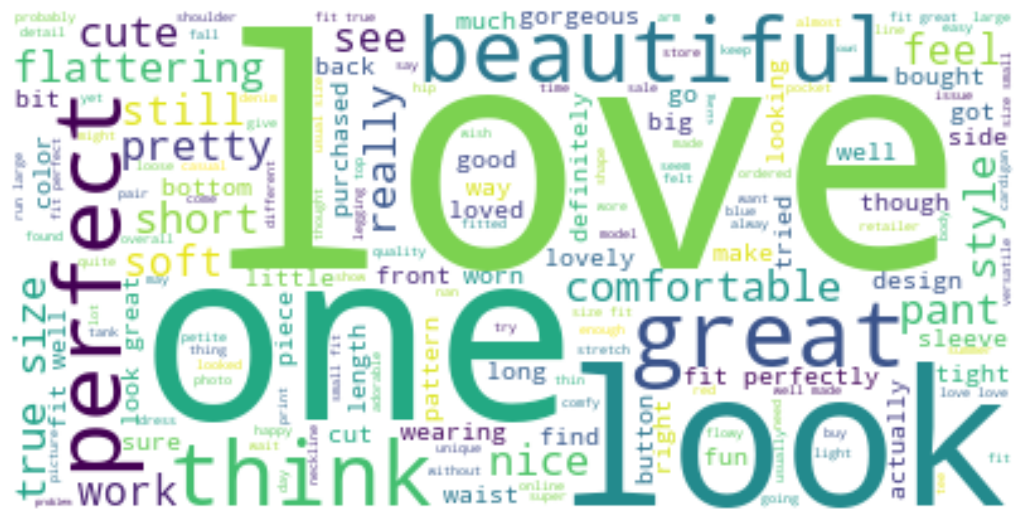

In [87]:
wordcloud = WordCloud(background_color="white", max_words=len(positive_words))

wordcloud.generate(positive_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Most Common words in not Recommended Review**

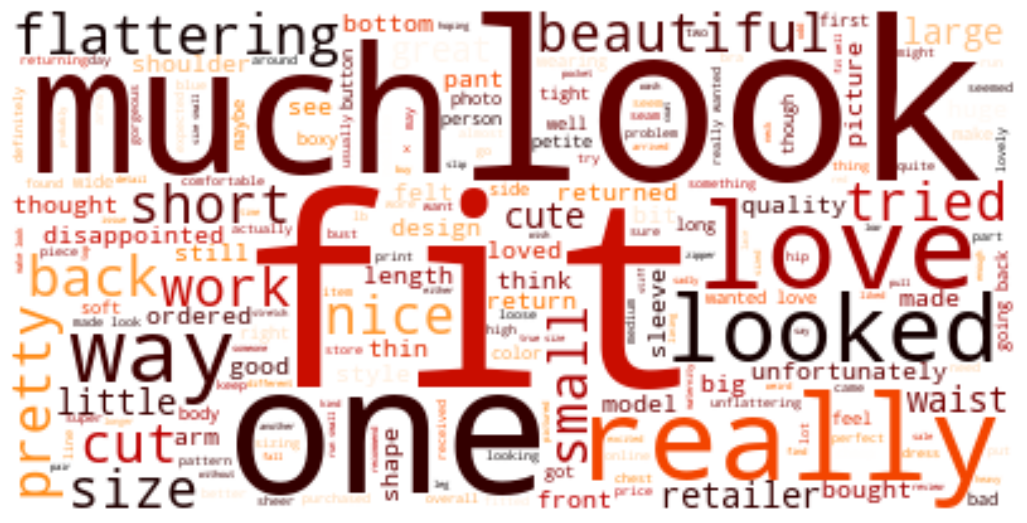

In [88]:
wordcloud = WordCloud(background_color="white", max_words=len(negative_words), colormap='gist_heat')

wordcloud.generate(negative_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [89]:
text['Sentiment'].value_counts()

Sentiment
1    19314
0     4172
Name: count, dtype: int64

Since our dataset is very unbalanced we try to remove more than half of positive reviews so that the model does not learn to always say positive

In [90]:
positive_df = text[text['Sentiment'] == 1] 
negative_df = text[text['Sentiment'] == 0]


positive_df_undersampled = positive_df.sample(n=8000, random_state=42) 


balanced_df = pd.concat([positive_df_undersampled, negative_df])


balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

text = balanced_df

text['Sentiment'].value_counts()

Sentiment
1    8000
0    4172
Name: count, dtype: int64

Spliting the data into train and test sets:

In [91]:
X = text['Review']
y = text['Sentiment']

X_train_sentences, X_test_sentences, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

**Tokenizing the words:**

Cause our data is text data, it has to be converted into numerical form since that’s what the deep learning model expects. 
To convert sentences into numerical representations we use `Tokenizer`, which removes punctuation marks and special characters and converts the sentence to lowercase letter. 

In [92]:
vocab_size = 5000
embedding_dim = 16
max_len = 100
trunction_type='post'
padding_type='post'
oov_token = "<OOV>"
X_train_sentences = X_train_sentences.apply(str)
X_test_sentences = X_test_sentences.apply(str)

In [93]:
tokenize = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenize.fit_on_texts(X_train_sentences)

The word index show us how words are mapped into numbers:

In [94]:
word_index = tokenize.word_index

By use `texts_to_sequences` from the tokenizer we convert the words into sequences so that a complete sequence of numbers can represent every sentence. 

In [95]:
X_train = tokenize.texts_to_sequences(X_train_sentences)
X_test = tokenize.texts_to_sequences(X_test_sentences)

Now we add padding to our data by using `pad_sequences`function to make it uniform.

In [96]:
X_train_pad = pad_sequences(X_train,maxlen=max_len, padding=padding_type, 
                            truncating=trunction_type)

X_test_pad = pad_sequences(X_test,maxlen=max_len, padding=padding_type, 
                           truncating=trunction_type)

### **GloVe Embeddings**
We use pre-trained word embeddings to create own embedding layer. We loading the Glove embeddings and append them to a dictionary. 

Next we use this dictionary to create an embedding matrix for each word in the training set. 

In [97]:
embeddings_index = {}
f = open('/tmp/glove/glove.6B.100d.txt', encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    try:
       coefs = np.asarray(values[1:], dtype='float32')
       embeddings_index[word] = coefs
    except ValueError:
       pass
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [98]:
num_words = len(word_index) + 1

embedding_matrix = np.zeros((num_words, max_len))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word) 
    if embedding_vector is not None:

        embedding_matrix[i] = embedding_vector

Finally we create the embedding layer:


In [99]:
embedding_layer = Embedding(num_words,
                            max_len,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

### **Build the model**
We create a model using embedding layer and Bidirectional LSTM layers. Bidirectional LSTMs are supported in Keras via the Bidirectional layer wrapper and it  takes a recurrent layer (e.g. the first LSTM layer) as an argument.

In [100]:
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(embedding_dim, return_sequences=True)), 
    Bidirectional(LSTM(embedding_dim)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          850600    
                                                                 
 bidirectional_6 (Bidirecti  (None, 100, 32)           14976     
 onal)                                                           
                                                                 
 bidirectional_7 (Bidirecti  (None, 32)                6272      
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 6)                 198       
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 872053 (3.33 MB)
Trainable params: 21453

We train the model for 10 epoch:

In [101]:
history = model.fit(X_train_pad, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test_pad, y_test),
                    verbose=1)

Epoch 1/10
305/305 [==============================] - 19s 49ms/step - loss: 0.5417 - accuracy: 0.7211 - val_loss: 0.4760 - val_accuracy: 0.7688
Epoch 2/10
305/305 [==============================] - 14s 46ms/step - loss: 0.4458 - accuracy: 0.7947 - val_loss: 0.4121 - val_accuracy: 0.8156
Epoch 3/10
305/305 [==============================] - 14s 46ms/step - loss: 0.4018 - accuracy: 0.8189 - val_loss: 0.4029 - val_accuracy: 0.8144
Epoch 4/10
305/305 [==============================] - 14s 45ms/step - loss: 0.3680 - accuracy: 0.8372 - val_loss: 0.3745 - val_accuracy: 0.8361
Epoch 5/10
305/305 [==============================] - 17s 57ms/step - loss: 0.3486 - accuracy: 0.8519 - val_loss: 0.3661 - val_accuracy: 0.8402
Epoch 6/10
305/305 [==============================] - 15s 50ms/step - loss: 0.3307 - accuracy: 0.8562 - val_loss: 0.3918 - val_accuracy: 0.8324
Epoch 7/10
305/305 [==============================] - 16s 52ms/step - loss: 0.3157 - accuracy: 0.8672 - val_loss: 0.3663 - val_accuracy:

Predictions on a test set:

In [102]:
loss, accuracy = model.evaluate(X_test_pad,y_test)
print('Test accuracy :', accuracy)

77/77 [==============================] - 1s 13ms/step - loss: 0.4241 - accuracy: 0.8070
Test accuracy : 0.8069815039634705


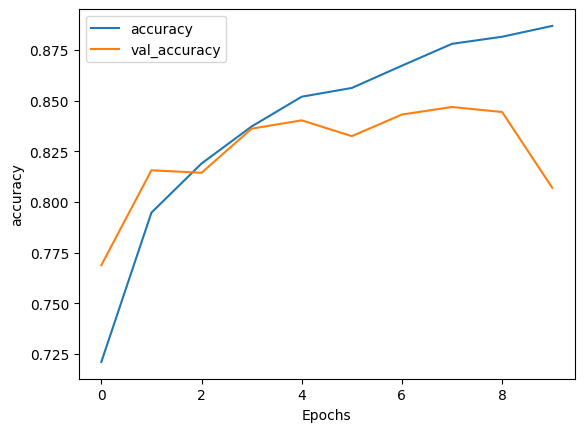

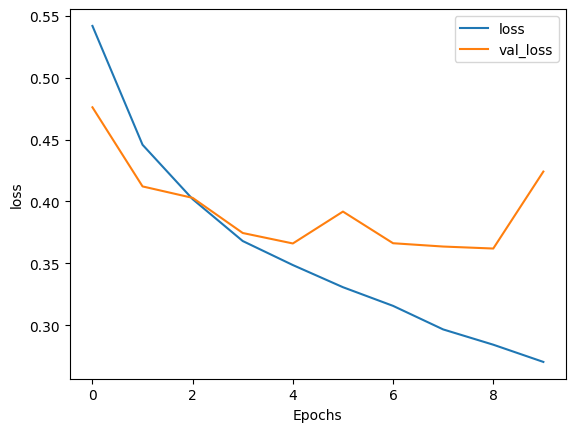

In [103]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [104]:
model.save("sentiment_model.h5")

**Model 2**

We also test a second model with a Dropout layer for decrease overfitting and  we increase number of epochs to 20.

In [105]:
model2 = Sequential([
    embedding_layer,
    Bidirectional(LSTM(64, return_sequences=True)), 
    Bidirectional(LSTM(32)),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

optimizer = tf.keras.optimizers.Adam(lr=1e-4)
model2.compile(loss='binary_crossentropy', 
               optimizer=optimizer,
               metrics=['accuracy'])

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          850600    
                                                                 
 bidirectional_8 (Bidirecti  (None, 100, 128)          84480     
 onal)                                                           
                                                                 
 bidirectional_9 (Bidirecti  (None, 64)                41216     
 onal)                                                           
                                                                 
 dense_8 (Dense)             (None, 16)                1040      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                

In [106]:
callbacks = EarlyStopping(monitor = 'val_accuracy', 
                          mode = 'max', 
                          patience = 3,
                          verbose = 1)

In [107]:
history2 = model2.fit(X_train_pad, y_train,
                    batch_size=32,
                    epochs=20,
                    validation_data=(X_test_pad, y_test),
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/20
305/305 [==============================] - 25s 69ms/step - loss: 0.5743 - accuracy: 0.6897 - val_loss: 0.4759 - val_accuracy: 0.7770
Epoch 2/20
305/305 [==============================] - 21s 69ms/step - loss: 0.4674 - accuracy: 0.7861 - val_loss: 0.4430 - val_accuracy: 0.7910
Epoch 3/20
305/305 [==============================] - 21s 69ms/step - loss: 0.4239 - accuracy: 0.8155 - val_loss: 0.4167 - val_accuracy: 0.7943
Epoch 4/20
305/305 [==============================] - 21s 68ms/step - loss: 0.3832 - accuracy: 0.8378 - val_loss: 0.3894 - val_accuracy: 0.8304
Epoch 5/20
305/305 [==============================] - 22s 72ms/step - loss: 0.3581 - accuracy: 0.8487 - val_loss: 0.3682 - val_accuracy: 0.8382
Epoch 6/20
305/305 [==============================] - 21s 68ms/step - loss: 0.3351 - accuracy: 0.8605 - val_loss: 0.3709 - val_accuracy: 0.8411
Epoch 7/20
305/305 [==============================] - 20s 67ms/step - loss: 0.3158 - accuracy: 0.8699 - val_loss: 0.3749 - val_accuracy:

In [108]:
loss, accuracy = model2.evaluate(X_test_pad,y_test)
print('Test accuracy :', accuracy)

77/77 [==============================] - 2s 23ms/step - loss: 0.4500 - accuracy: 0.8415
Test accuracy : 0.8414784669876099


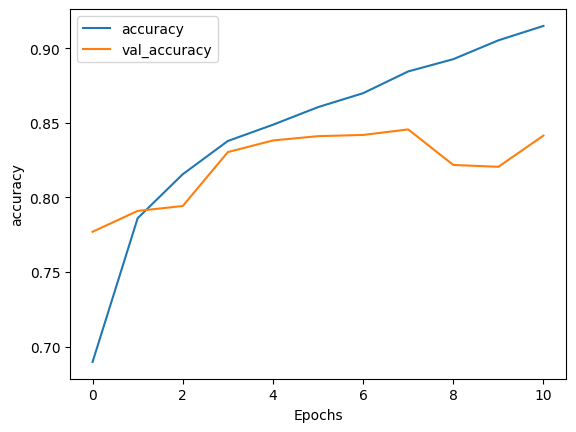

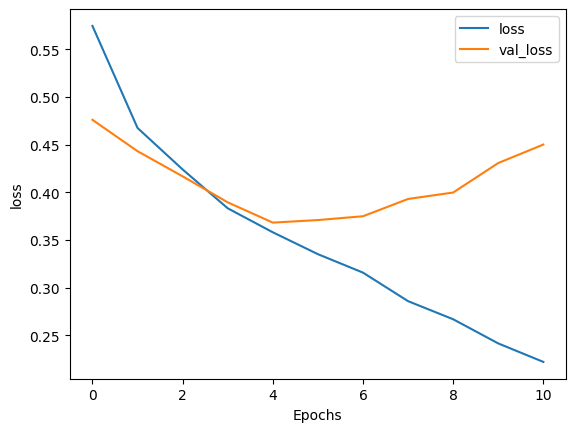

In [109]:
plot_graphs(history2, "accuracy")
plot_graphs(history2, "loss")

In [110]:
model2.save("model2.h5")

import pickle

with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenize, f)

print("Tokenizer saved to tokenizer.pkl")

Tokenizer saved to tokenizer.pkl


In [142]:
from tensorflow.keras.models import load_model
model3 = load_model("model2.h5")

test_sentence = "run small esp zipper area run ordered sp typically fit tight look feel cheap pulling cause rip pretty disappointed going christmas year needle say going back"

test_sequence = tokenize.texts_to_sequences([test_sentence])

test_padded = pad_sequences(test_sequence,maxlen=max_len, padding=padding_type, 
                            truncating=trunction_type)

prediction = model3.predict(test_padded)



if prediction[0][0] > 0.5:
    print(f"Positive sentiment with confidence {prediction[0][0]:.2f}")
else:
    print(f"Negative sentiment with confidence {1 - prediction[0][0]:.2f}")



1/1 [==============================] - 1s 1s/step
Negative sentiment with confidence 0.94


# Now we are done with developing a sentiment analysis model for our Application. However there are two more tasks remaining

Since we are doing aspect based sentiment analysis that is we are not telling whether the overall review is positive or not but rather doing it at a more granular level by dividing the sentence into multiple simple sentences and identifying the aspect of the cloth the sentence is talking about and then doing sentiment analysis on it

So first task is to do Sentence Boundary Segmentation that is we have a large paragraph and have to segment it into multiple sentences

For that we will be using the AI Model trained for this specific problem to split the sentence for us. Reason for using AI model is that not every full stop is working as full stop it can be used as abbreviation as such so we cannot use basic english rules do to the segmentation for us

In [111]:
from wtpsplit import SaT

sat_sm = SaT("sat-12l-sm")
sat_sm.half().to("cuda")
sat_sm.split("The material is soft the design is stylish. However, I feel it lacks durability for regular use.")

['The material is soft ',
 'the design is stylish. ',
 'However, I feel it lacks durability for regular use.']

# And now the second task is to classify and identify which aspect is present in the sentence

For this we did not have any dataset available because it is such a niche problem so we created a synthetic dataset by deploying a local LLM LLAMA 3.1:8B model and generating the dataset for ourselves

For this project we considered 8 aspect that can be possibly present in a review

1. Fit
2. Color
3. Category
4. Price
5. Design
6. Fabric
7. Comfort
8. Durability


In [ ]:
import ollama
import pandas as pd

aspects = ["Fit", "Fabric", "Color", "Design", "Durability", "Price", "Comfort", "Category", "None of these"]
sentiments = ["Positive", "Negative", "Mixed"]

def generate_review(model_name, prompt):
    """
    Uses Ollama's chat API to generate a response for a given prompt.
    """
    try:
        response = ollama.chat(model=model_name, messages=[{'role': 'user', 'content': prompt}])
        return response['message']['content'].strip()
    except Exception as e:
        print(f"Error for prompt '{prompt}': {e}")
        return None

rows = []
model_name = "llama3.1:8b"

for aspect in aspects:
        for _ in range(500):
            #prompt = f"Rephrase the sentence \"Write a small review whether positive, negative or mixed of a piece of cloth u bought (could be anything shirt, trouser etc) focusing on the aspect: {aspect}\""
            prompt = f"Write a small review whether positive, negative or mixed of a piece of cloth u bought (could be anything shirt, trouser etc) focusing on the aspect: {aspect}/ write at most 2 sentences and dont write anything except review, use casual and simple english. Make it as unique as possible. dont use punctuations"
            print(f"\nGenerating review for Aspect: {aspect}")

            response = generate_review(model_name, prompt)


            if response:
                print(f"Response: {response}\n")
                rows.append({"Review": response, "Aspect": aspect})

df = pd.DataFrame(rows)
df.to_csv("synthetic_reviews_dataset2.csv", index=False)
print("\nDataset saved to synthetic_reviews_dataset.csv!")



Generating review for Aspect: Fit
Response: The fit is spot on I just wish it was a bit longer to break the monotony of my usual shorts game


Generating review for Aspect: Fit
Response: I'm really surprised how this flowy sundress fits me like a glove but somehow the sleeves are too tight to move my arms freely which is kinda annoying


Generating review for Aspect: Fit
Response: It's way too loose in some areas but surprisingly tight in others making me feel like a stuffed sausage trying to squeeze into skinny jeans 

On the other hand it fits perfectly around my midsection but hangs awkwardly on the sides


Generating review for Aspect: Fit
Response: It's a weird fit this shirt has its tight around the arms but loose everywhere else like I'm wearing a baggy jacket with sleeves that have shrunk to half their size


Generating review for Aspect: Fit
Response: I was really hoping for a slim fit but this cloth is a full blown tent - it swallows me whole no matter how I try to squeeze i

We had to clean this synthetic data since it had a few errors

In [ ]:
import pandas as pd
import re


file_path = "synthetic_reviews_dataset2.csv" 
df = pd.read_csv(file_path)


def clean_reviews(review):
    
    if re.search(r"\s[Oo][rR]\s", review):  

        parts = re.split(r"\s[Oo][rR]\s", review, maxsplit=1)
        return parts[0].strip()
    return review


df["Review"] = df["Review"].apply(clean_reviews)

output_file = "cleaned_dataset2.csv"
df.to_csv(output_file, index=False)

print(f"Cleaned dataset saved to {output_file}!")

Cleaned dataset saved to cleaned_dataset2.csv!


# Training BERT Transformer on Aspect Classification

In [113]:
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv("cleaned_dataset2.csv")

train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["Review"].tolist(),
    df["Aspect"].tolist(),
    test_size=0.2,
    random_state=42
)


label_mapping = {label: idx for idx, label in enumerate(df["Aspect"].unique())}
train_labels = [label_mapping[label] for label in train_labels]
test_labels = [label_mapping[label] for label in test_labels]


print("Label Mapping:", label_mapping)

Label Mapping: {'Fit': 0, 'Fabric': 1, 'Color': 2, 'Design': 3, 'Durability': 4, 'Price': 5, 'Comfort': 6, 'Category': 7, 'None of these': 8}


In [114]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")


def tokenize_data(texts, labels):
    return tokenizer(
        texts,
        max_length=128,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    ), torch.tensor(labels)

import torch
train_encodings, train_labels = tokenize_data(train_texts, train_labels)
test_encodings, test_labels = tokenize_data(test_texts, test_labels)

In [115]:
from torch.utils.data import Dataset

class AspectDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx]
        }


train_dataset = AspectDataset(train_encodings, train_labels)
test_dataset = AspectDataset(test_encodings, test_labels)

In [116]:
from transformers import BertForSequenceClassification


num_labels = len(label_mapping)
model_bert = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels=num_labels
)

  0%|          | 0/450 [00:00<?, ?it/s]

{'loss': 2.1962, 'grad_norm': 7.778870582580566, 'learning_rate': 4.888888888888889e-05, 'epoch': 0.04}
{'loss': 2.0402, 'grad_norm': 6.567108631134033, 'learning_rate': 4.7777777777777784e-05, 'epoch': 0.09}
{'loss': 1.7631, 'grad_norm': 6.787618637084961, 'learning_rate': 4.666666666666667e-05, 'epoch': 0.13}
{'loss': 1.4918, 'grad_norm': 6.481498718261719, 'learning_rate': 4.555555555555556e-05, 'epoch': 0.18}
{'loss': 1.1133, 'grad_norm': 7.631810188293457, 'learning_rate': 4.4444444444444447e-05, 'epoch': 0.22}
{'loss': 0.9394, 'grad_norm': 6.356473922729492, 'learning_rate': 4.3333333333333334e-05, 'epoch': 0.27}
{'loss': 0.8729, 'grad_norm': 5.977303504943848, 'learning_rate': 4.222222222222222e-05, 'epoch': 0.31}
{'loss': 0.7316, 'grad_norm': 5.831695079803467, 'learning_rate': 4.111111111111111e-05, 'epoch': 0.36}
{'loss': 0.7025, 'grad_norm': 18.898862838745117, 'learning_rate': 4e-05, 'epoch': 0.4}
{'loss': 0.5101, 'grad_norm': 6.673990726470947, 'learning_rate': 3.888888888

  0%|          | 0/57 [00:00<?, ?it/s]

Classification Report:
                precision    recall  f1-score   support

          Fit       0.97      0.97      0.97       110
       Fabric       0.85      0.98      0.91        94
        Color       0.99      0.91      0.95       107
       Design       0.83      0.99      0.91        92
   Durability       0.96      0.99      0.97        96
        Price       0.99      0.98      0.99       107
      Comfort       0.89      0.90      0.89        86
     Category       0.96      0.82      0.89        97
None of these       0.89      0.80      0.84       111

     accuracy                           0.93       900
    macro avg       0.93      0.93      0.92       900
 weighted avg       0.93      0.93      0.93       900



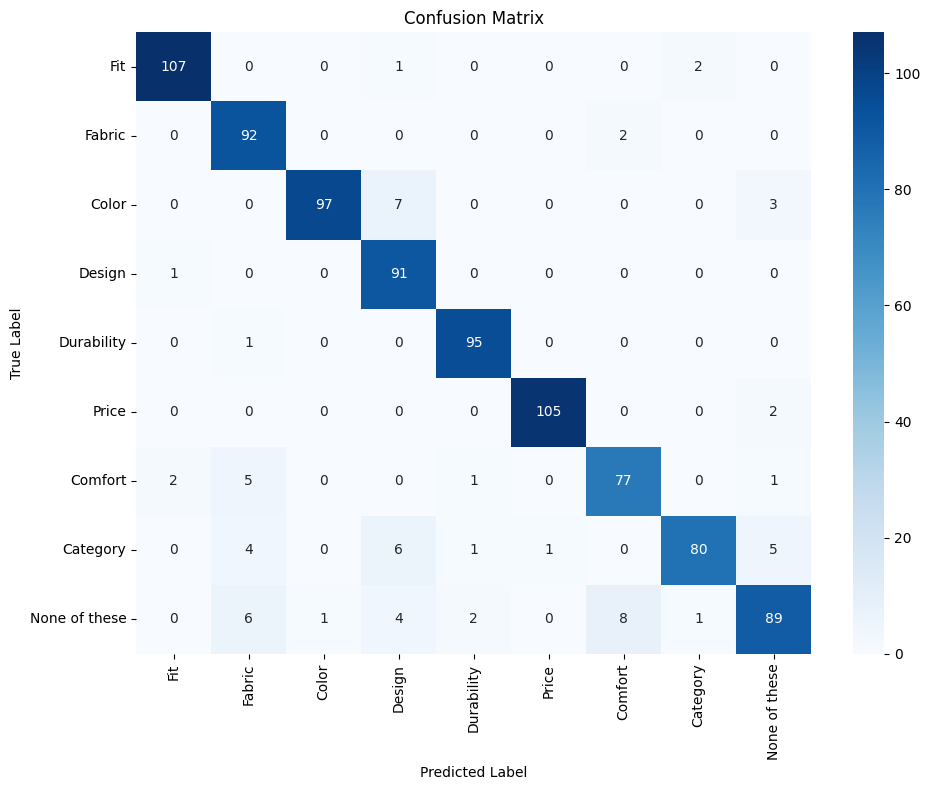

{'eval_loss': 0.26225143671035767, 'eval_accuracy': 0.9255555555555556, 'eval_precision': 0.9292225259780217, 'eval_recall': 0.9255555555555556, 'eval_f1': 0.9251490519746319, 'eval_runtime': 2.7662, 'eval_samples_per_second': 325.352, 'eval_steps_per_second': 20.606, 'epoch': 1.0}
{'loss': 0.2959, 'grad_norm': 6.080580234527588, 'learning_rate': 2.4444444444444445e-05, 'epoch': 1.02}
{'loss': 0.1551, 'grad_norm': 5.667140007019043, 'learning_rate': 2.3333333333333336e-05, 'epoch': 1.07}
{'loss': 0.2229, 'grad_norm': 12.612378120422363, 'learning_rate': 2.2222222222222223e-05, 'epoch': 1.11}
{'loss': 0.1582, 'grad_norm': 1.3872090578079224, 'learning_rate': 2.111111111111111e-05, 'epoch': 1.16}
{'loss': 0.217, 'grad_norm': 0.42058712244033813, 'learning_rate': 2e-05, 'epoch': 1.2}
{'loss': 0.2738, 'grad_norm': 6.288461208343506, 'learning_rate': 1.888888888888889e-05, 'epoch': 1.24}
{'loss': 0.2307, 'grad_norm': 3.661384105682373, 'learning_rate': 1.777777777777778e-05, 'epoch': 1.29}


  0%|          | 0/57 [00:00<?, ?it/s]

Classification Report:
                precision    recall  f1-score   support

          Fit       0.98      0.96      0.97       110
       Fabric       0.93      0.99      0.96        94
        Color       0.97      0.98      0.98       107
       Design       0.97      0.96      0.96        92
   Durability       0.95      0.99      0.97        96
        Price       0.99      1.00      1.00       107
      Comfort       0.89      0.95      0.92        86
     Category       0.96      0.93      0.94        97
None of these       0.94      0.84      0.89       111

     accuracy                           0.95       900
    macro avg       0.95      0.96      0.95       900
 weighted avg       0.95      0.95      0.95       900



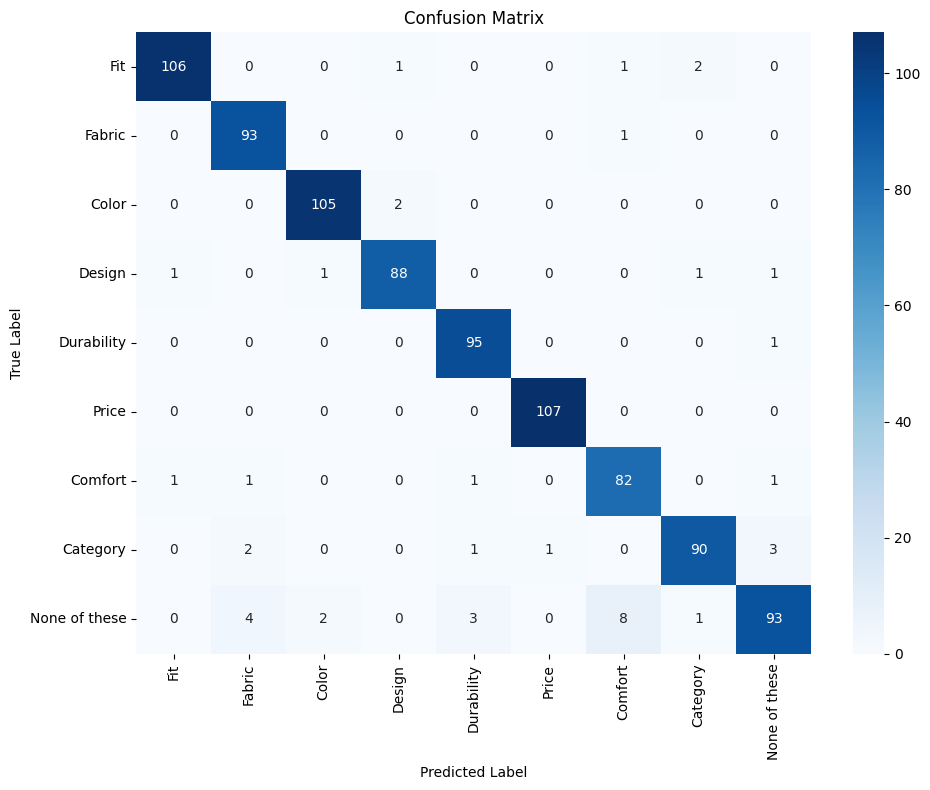

{'eval_loss': 0.1761949509382248, 'eval_accuracy': 0.9544444444444444, 'eval_precision': 0.9548714161981507, 'eval_recall': 0.9544444444444444, 'eval_f1': 0.9540178822616053, 'eval_runtime': 2.7198, 'eval_samples_per_second': 330.902, 'eval_steps_per_second': 20.957, 'epoch': 2.0}
{'train_runtime': 100.0887, 'train_samples_per_second': 71.936, 'train_steps_per_second': 4.496, 'train_loss': 0.4623689929644267, 'epoch': 2.0}


TrainOutput(global_step=450, training_loss=0.4623689929644267, metrics={'train_runtime': 100.0887, 'train_samples_per_second': 71.936, 'train_steps_per_second': 4.496, 'total_flos': 473629665484800.0, 'train_loss': 0.4623689929644267, 'epoch': 2.0})

In [117]:
import torch
from torch.utils.data import DataLoader
from transformers import AdamW, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

aspect_label_mapping = {
    'Fit': 0,
    'Fabric': 1,
    'Color': 2,
    'Design': 3,
    'Durability': 4,
    'Price': 5,
    'Comfort': 6,
    'Category': 7,
    'None of these': 8
}
aspect_labels = {v: k for k, v in aspect_label_mapping.items()} 

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    precision, recall, f1, support = precision_recall_fscore_support(labels, preds, average='weighted')
    
    accuracy = accuracy_score(labels, preds)
    
    class_report = classification_report(labels, preds, target_names=list(aspect_labels.values()))
    print("Classification Report:\n", class_report)
    
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(labels, preds)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=list(aspect_labels.values()), 
                yticklabels=list(aspect_labels.values()))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show() 
    plt.close()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

def plot_training_metrics(trainer):
    logs = trainer.state.log_history
    
    train_logs = [log for log in logs if 'loss' in log and 'eval_loss' not in log]
    eval_logs = [log for log in logs if 'eval_loss' in log]
    
    train_steps = [log['step'] for log in train_logs]
    train_losses = [log['loss'] for log in train_logs]
    
    eval_steps = [log['step'] for log in eval_logs]
    eval_losses = [log['eval_loss'] for log in eval_logs]
    eval_accuracies = [log.get('eval_accuracy', 0) for log in eval_logs]
    

    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(train_steps, train_losses, label='Training Loss', color='blue')
    
    plt.title('Training Accuracy and Loss')
    plt.xlabel('Training Steps')
    plt.ylabel('Percentage')
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(eval_steps, eval_losses, label='Evaluation Loss', color='green')
    plt.plot(eval_steps, eval_accuracies, label='Evaluation Accuracy', color='orange')
    plt.title('Evaluation Accuracy and Loss')
    plt.xlabel('Evaluation Steps')
    plt.ylabel('Percentage')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    plt.close()

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True
)

trainer = Trainer(
    model=model_bert,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  
)

trainer.train()

In [135]:

save_directory = "./aspect_classification_model2"


model_bert.save_pretrained(save_directory)


tokenizer.save_pretrained(save_directory)

print(f"Model and tokenizer saved to {save_directory}.")

Model and tokenizer saved to ./aspect_classification_model2.


In [136]:
from transformers import BertForSequenceClassification, BertTokenizer
save_directory = "./aspect_classification_model2"

loaded_model = BertForSequenceClassification.from_pretrained(save_directory)


loaded_tokenizer = BertTokenizer.from_pretrained(save_directory)

print("Model and tokenizer loaded successfully.")

Model and tokenizer loaded successfully.


In [137]:
import torch

custom_sentence = " i bought a petite and am 5'8.  i love the length on me- hits just a little below the knee. "


inputs = loaded_tokenizer(custom_sentence, return_tensors="pt", truncation=True, padding="max_length", max_length=128)


outputs = loaded_model(**inputs)
predicted_label = torch.argmax(outputs.logits, dim=1).item()


aspect_name = aspect_labels[predicted_label]

print(f"Predicted Aspect: {aspect_name}")

Predicted Aspect: Fit


So now we are also done with training the model for aspect classification and now all necessary AI models are in place

1. Sentiment Analysis Model
2. Sentence Segmentation Model
3. Aspect Classification Model

# EVALUATION AND VISUALIZATION

This evaluation and visualization is of the models of Sentiment Analysis

# Model 1

Test Loss: 0.42412886023521423
Test Accuracy: 0.8069815039634705
77/77 [==============================] - 1s 11ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.67      0.87      0.75       827
    Positive       0.92      0.78      0.84      1608

    accuracy                           0.81      2435
   macro avg       0.79      0.82      0.80      2435
weighted avg       0.83      0.81      0.81      2435


Confusion Matrix:
[[ 718  109]
 [ 361 1247]]
Precision: 0.9196
Recall: 0.7755
F1-Score: 0.8414
Accuracy: 0.8070


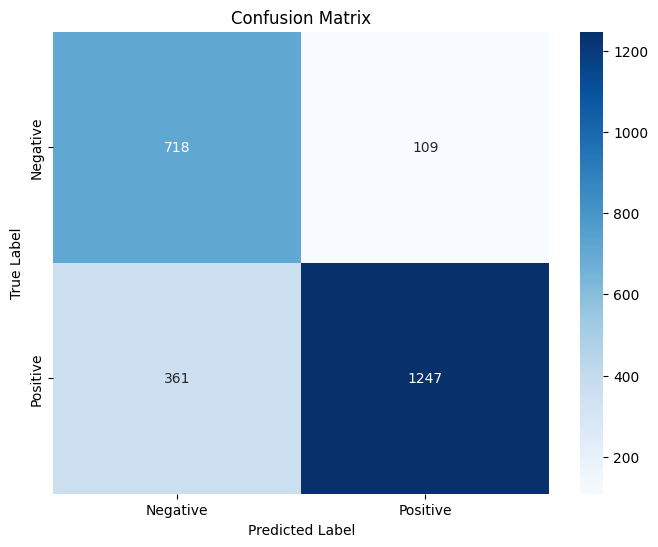

In [138]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import numpy as np


loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

y_pred = model.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Positive']))

conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average="binary")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Model 2

Test Loss: 0.44998958706855774
Test Accuracy: 0.8414784669876099
77/77 [==============================] - 2s 21ms/step

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.73      0.76       827
    Positive       0.87      0.90      0.88      1608

    accuracy                           0.84      2435
   macro avg       0.83      0.81      0.82      2435
weighted avg       0.84      0.84      0.84      2435


Confusion Matrix:
[[ 602  225]
 [ 161 1447]]
Precision: 0.8654
Recall: 0.8999
F1-Score: 0.8823
Accuracy: 0.8415


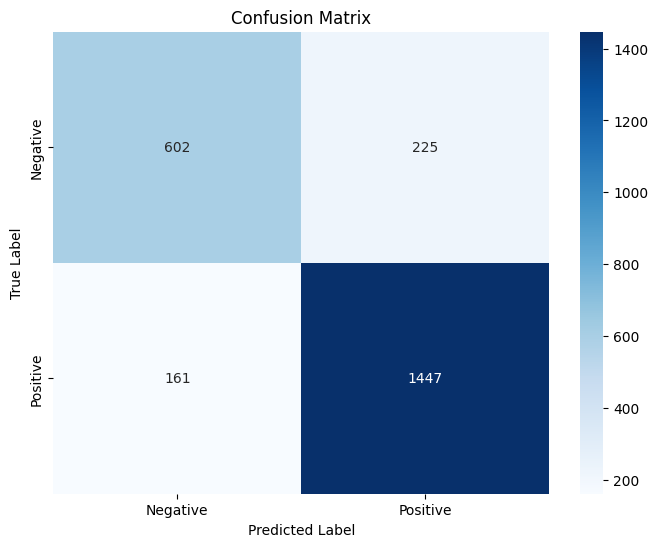

In [139]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import numpy as np

loss, accuracy = model2.evaluate(X_test_pad, y_test, verbose=0)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

y_pred = model2.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype(int)

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Positive']))

conf_matrix = confusion_matrix(y_test, y_pred_classes)
print("\nConfusion Matrix:")
print(conf_matrix)

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred_classes, average="binary")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

accuracy = accuracy_score(y_test, y_pred_classes)
print(f"Accuracy: {accuracy:.4f}")

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Results

Our model 2 performs a bit better since the data is more skewed towards positive sentiment and it classifies more negative review correctly than model 1

# Aspect Classification Model

Now we will evaluate the aspect classification model and visualize the results

  0%|          | 0/57 [00:00<?, ?it/s]

Classification Report:
                precision    recall  f1-score   support

          Fit       0.98      0.96      0.97       110
       Fabric       0.93      0.99      0.96        94
        Color       0.97      0.98      0.98       107
       Design       0.97      0.96      0.96        92
   Durability       0.95      0.99      0.97        96
        Price       0.99      1.00      1.00       107
      Comfort       0.89      0.95      0.92        86
     Category       0.96      0.93      0.94        97
None of these       0.94      0.84      0.89       111

     accuracy                           0.95       900
    macro avg       0.95      0.96      0.95       900
 weighted avg       0.95      0.95      0.95       900



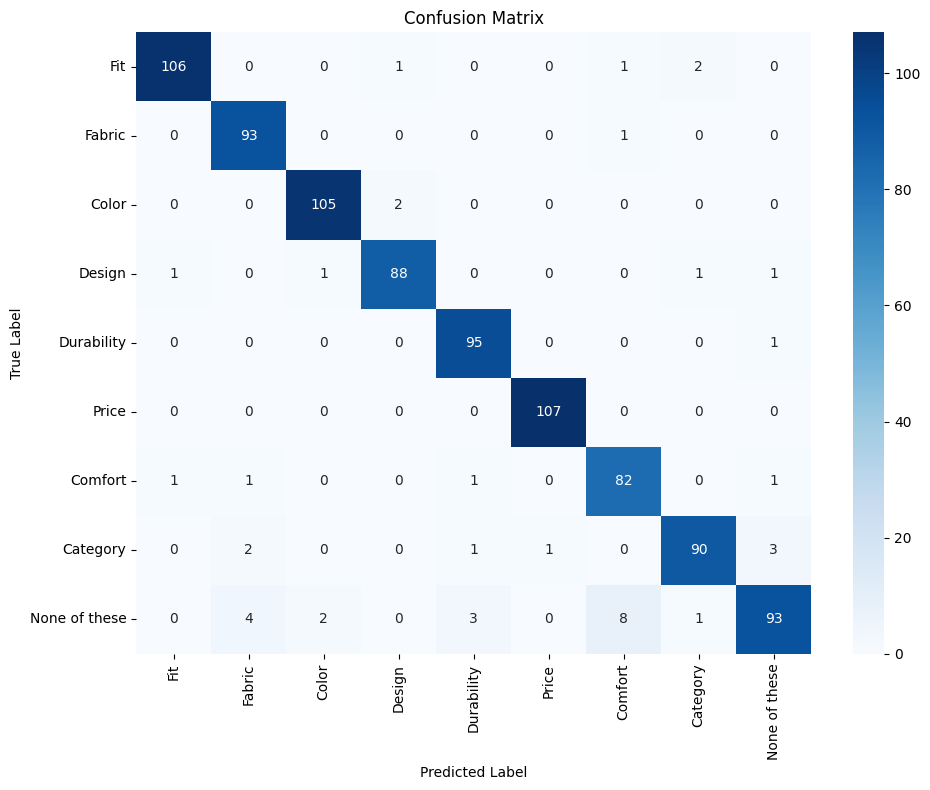

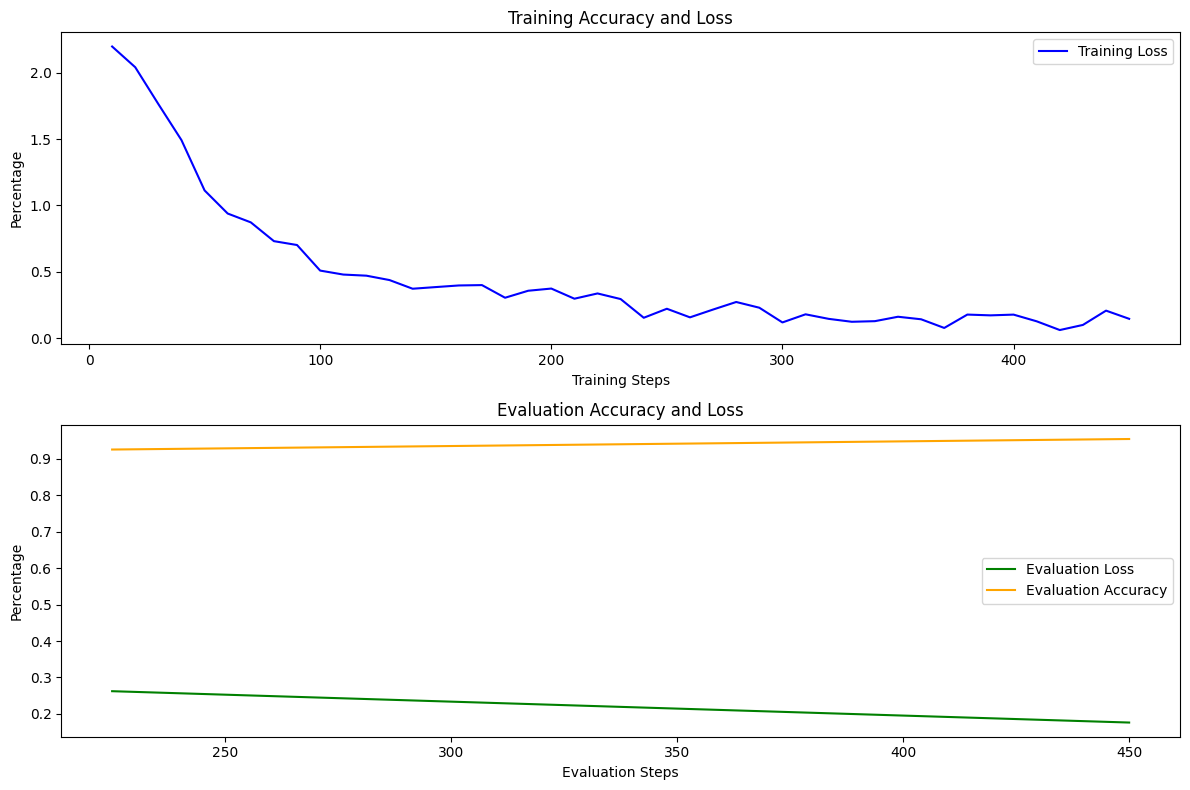

Evaluation Results: {'eval_loss': 0.1761949509382248, 'eval_accuracy': 0.9544444444444444, 'eval_precision': 0.9548714161981507, 'eval_recall': 0.9544444444444444, 'eval_f1': 0.9540178822616053, 'eval_runtime': 2.7843, 'eval_samples_per_second': 323.236, 'eval_steps_per_second': 20.472, 'epoch': 2.0}


In [140]:
eval_results = trainer.evaluate()

plot_training_metrics(trainer)

print("Evaluation Results:", eval_results)

# FLASK APPLICATION CODE FOR RUNNING THE RECOMMENDER SYSTEM

We used a basic recommendation system where we just simply make a profile for every user and product. We create a profile of user by considering which aspects are important from him as shown by his reviews. And we create a profile of product having a score regarding each aspect given by the users review. Then we recommend those products which score high on the user's preferred preferences.

In [ ]:
from flask import Flask, render_template, request, jsonify, session, redirect, url_for, send_from_directory
import sqlite3
import os

import re
from transformers import BertForSequenceClassification, BertTokenizer
import torch
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle
import spacy
from wtpsplit import SaT
from textblob import TextBlob
from nltk.stem import WordNetLemmatizer
import contractions

vocab_size = 5000
embedding_dim = 16
max_len = 100
trunction_type='post'
padding_type='post'
oov_token = "<OOV>"
from nltk.corpus import stopwords

aspect_model_dir = "./aspect_classification_model2"
aspect_model = BertForSequenceClassification.from_pretrained(aspect_model_dir)
aspect_tokenizer = BertTokenizer.from_pretrained(aspect_model_dir)
# spacy.cli.download("en_core_web_sm")

sentiment_model_path = "sentiment_model.h5"
sentiment_model = load_model(sentiment_model_path)
import string

with open("tokenizer.pkl", "rb") as f:
    sentiment_tokenizer = pickle.load(f)

def preprocessing(review):
    review = review.lower()
    review = review.translate(str.maketrans('', '', string.punctuation))


    conjunctions = r'\b(and|but|or|so|because|however|therefore|although|though|yet)\b'

    result = re.sub(conjunctions, '', review, flags=re.IGNORECASE)

    result = re.sub(r'\s+', ' ', result).strip()

    
    lemmatizer = WordNetLemmatizer()
    review = " ".join(lemmatizer.lemmatize(word) for word in review.split())
    review = contractions.fix(review)
    review = " ".join(review.split())

    return review

# nlp = spacy.load("en_core_web_sm")
# print("SpaCy model loaded successfully!")


# def split_sentences_spacy(text):
#     doc = nlp(text)
#     sentences = [sent.text.strip() for sent in doc.sents]
#     return sentences


def split_sentences_sat(text):
    sat_sm = SaT("sat-12l-sm")
    sat_sm.half().to("cuda")
    return sat_sm.split(text)

def split_into_sentences(review):
    sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', review)
    return [sentence.strip() for sentence in sentences if sentence.strip()]

def classify_aspect(sentence):
    inputs = aspect_tokenizer(sentence, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    outputs = aspect_model(**inputs)
    predicted_label = torch.argmax(outputs.logits, dim=1).item()
    aspect_map = {0: "Fit", 1: "Fabric", 2: "Color", 3: "Design", 4: "Durability", 5: "Price", 6: "Comfort", 7: "Category", 8: "None of these"}
    return aspect_map[predicted_label]

def analyze_sentiment(sentence):
    test_sequence = sentiment_tokenizer.texts_to_sequences([sentence])
    test_padded = pad_sequences(test_sequence, maxlen=max_len, padding=padding_type, truncating=trunction_type)

    prediction = sentiment_model.predict(test_padded)
    return "Positive" if prediction[0][0] > 0.5 else "Negative"
    


app = Flask(__name__)
app.secret_key = 'your_secret_key'

DATABASE = 'absa.db'

def initialize_database():
     with sqlite3.connect(DATABASE) as conn:
        cursor = conn.cursor()
        
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS users (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                username TEXT UNIQUE NOT NULL,
                password TEXT NOT NULL,
                role TEXT NOT NULL DEFAULT 'user',
                fit_preference REAL DEFAULT 0,
                fabric_preference REAL DEFAULT 0,
                color_preference REAL DEFAULT 0,
                design_preference REAL DEFAULT 0,
                durability_preference REAL DEFAULT 0,
                price_preference REAL DEFAULT 0,
                comfort_preference REAL DEFAULT 0,
                category_preference REAL DEFAULT 0
            )
        ''')

        cursor.execute('SELECT * FROM users WHERE username = ?', ('admin',))
        if not cursor.fetchone():
            cursor.execute('INSERT INTO users (username, password, role) VALUES (?, ?, ?)', 
                            ('admin', 'admin', 'admin'))

        cursor.execute('''
            CREATE TABLE IF NOT EXISTS products (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                name TEXT NOT NULL,
                category TEXT NOT NULL,
                price REAL NOT NULL,
                color TEXT NOT NULL,
                size TEXT NOT NULL,
                image_path TEXT,
                fit_score REAL DEFAULT 0,
                fabric_score REAL DEFAULT 0,
                color_score REAL DEFAULT 0,
                design_score REAL DEFAULT 0,
                durability_score REAL DEFAULT 0,
                price_score REAL DEFAULT 0,
                comfort_score REAL DEFAULT 0,
                category_score REAL DEFAULT 0
            )
        ''')

        cursor.execute('''
            CREATE TABLE IF NOT EXISTS reviews (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                product_id INTEGER NOT NULL,
                username TEXT NOT NULL,
                content TEXT NOT NULL,
                date TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                FOREIGN KEY (product_id) REFERENCES products (id)
            )
        ''')

        conn.commit()

initialize_database()

def analyze_review_and_update_db(review, product_id):
    
    print(review)
    sentences = split_sentences_sat(review)
    print(sentences)
    cleaned_sentences = []
    for sentence in sentences:
        cleaned_sentences.append(preprocessing(sentence))
    print(cleaned_sentences)

    aspect_scores = {aspect: None for aspect in [
        "Fit", "Fabric", "Color", "Design", "Durability", "Price", "Comfort", "Category"
    ]}

    for sentence in sentences:
        aspect = classify_aspect(sentence)
        if aspect != "None of these" and aspect_scores[aspect] is None:
            sentiment = analyze_sentiment(sentence)
            score = 1 if sentiment == "Positive" else -1
            aspect_scores[aspect] = score
        
        print(aspect, sentence, sentiment)

    averaged_scores = {key: score if score is not None else 0 for key, score in aspect_scores.items()}

    with sqlite3.connect(DATABASE) as conn:
        cursor = conn.cursor()
        cursor.execute('''
            UPDATE products 
            SET fit_score = fit_score + ?,
                fabric_score = fabric_score + ?,
                color_score = color_score + ?,
                design_score = design_score + ?,
                durability_score = durability_score + ?,
                price_score = price_score + ?,
                comfort_score = comfort_score + ?,
                category_score = category_score + ?
            WHERE id = ?
        ''', (
            averaged_scores["Fit"],
            averaged_scores["Fabric"],
            averaged_scores["Color"],
            averaged_scores["Design"],
            averaged_scores["Durability"],
            averaged_scores["Price"],
            averaged_scores["Comfort"],
            averaged_scores["Category"],
            product_id
        ))
        conn.commit()

    return averaged_scores

@app.route('/static/uploads/<string:filename>')
def uploaded_file(filename):
    return send_from_directory('static/uploads', filename)

@app.route('/product/<int:product_id>')
def product_details(product_id):

    with sqlite3.connect(DATABASE) as conn:
        cursor = conn.cursor()
        cursor.execute('SELECT * FROM products WHERE id = ?', (product_id,))
        product = cursor.fetchone()

    if not product:
        return "Product not found", 404

    return render_template('review.html', product={
        'id': product[0],
        'name': product[1],
        'category': product[2],
        'price': product[3],
        'color': product[4],
        'size': product[5],
        'image': product[6]
    })

@app.route('/product/<int:product_id>/reviews', methods=['GET', 'POST'])
def product_reviews(product_id):
    with sqlite3.connect(DATABASE) as conn:
        cursor = conn.cursor()
        
        if request.method == 'GET':

            cursor.execute('SELECT username, content, date FROM reviews WHERE product_id = ?', (product_id,))
            reviews = cursor.fetchall()
            

            reviews_list = [
                {
                    'username': review[0], 
                    'content': review[1]
                } 
                for review in reviews
            ]
            
            return jsonify(reviews_list)
        
        elif request.method == 'POST':
            username = session.get('username', 'Anonymous')
            content = request.json.get('content')
            if not content:
                return jsonify({'status': 'error', 'message': 'Review cannot be empty'}), 400
    
            aspect_scores = analyze_review_and_update_db(content, product_id)
    

            cursor.execute(f'''
                UPDATE users
                SET {', '.join(f"{aspect.lower()}_preference = {aspect.lower()}_preference + ?" for aspect in aspect_scores.keys())}
                WHERE username = ?
            ''', [*[abs(score) for score in aspect_scores.values()], username])
            conn.commit()


            cursor.execute('INSERT INTO reviews (product_id, username, content) VALUES (?, ?, ?)',
                           (product_id, username, content))
            conn.commit()
            
            return jsonify({'status': 'success', 'message': 'Review added and analyzed successfully'})


def recommend_products(user_id):
    with sqlite3.connect(DATABASE) as conn:
        cursor = conn.cursor()
        

        cursor.execute('''
            SELECT fit_preference, fabric_preference, color_preference, design_preference, 
                   durability_preference, price_preference, comfort_preference, category_preference
            FROM users WHERE id = ?
        ''', (user_id,))
        user_preferences = cursor.fetchone()
        

        cursor.execute('''
            SELECT id, name, category, price, color, size, image_path, 
                   fit_score, fabric_score, color_score, design_score, 
                   durability_score, price_score, comfort_score, category_score
            FROM products
        ''')
        products = cursor.fetchall()
        
        recommendations = []
        for product in products:
            product_id, name, category, price, color, size, image_path, *scores = product
            similarity_score = sum(
                up * ps for up, ps in zip(user_preferences, scores)
            ) 
            recommendations.append({
                "id": product_id,
                "name": name,
                "category": category,
                "price": price,
                "color": color,
                "size": size,
                "image": image_path,
                "score": similarity_score,
            })
        

        recommendations.sort(key=lambda x: x["score"], reverse=True)

        print(recommendations)

        return recommendations[:5] 

@app.route('/recommend')
def recommend():
    if 'user_id' not in session:
        return redirect(url_for('login'))
    
    user_id = session['user_id']
    recommendations = recommend_products(user_id)
    return render_template('recommended.html', recommendations=recommendations)


@app.route('/signup', methods=['POST', 'GET'])
def signup():
    if request.method == 'POST':
        username = request.form.get('username')
        password = request.form.get('password')
        confirm_password = request.form.get('confirm_password')

        if password != confirm_password:
            return render_template('signup.html', message='Passwords do not match!')


        try:
            with sqlite3.connect(DATABASE) as conn:
                cursor = conn.cursor()
                print(username)
                print(password)
                cursor.execute('INSERT INTO users (username, password, role) VALUES (?, ?, ?)', (username, password, 'user'))
                conn.commit()
            return redirect(url_for('login', message='Account created successfully!'))
        except sqlite3.IntegrityError:
            return render_template('signup.html', message='Username already exists!')
    
    return render_template('signup.html')

@app.route('/login', methods=['GET', 'POST'])
def login():
    if request.method == 'POST':
        username = request.form.get('username')
        password = request.form.get('password')

        with sqlite3.connect(DATABASE) as conn:
            cursor = conn.cursor()
            cursor.execute('SELECT * FROM users WHERE username = ? AND password = ?', (username, password))
            user = cursor.fetchone()

        if user:
            session['username'] = username
            session['user_id'] = user[0]
            session['role'] = user[3] 

  
            if user[3] == 'admin':
                return redirect(url_for('admin_dashboard'))
            else:
                return redirect(url_for('user_dashboard'))
        else:
            return render_template('login.html', message='Invalid username or password')


    return render_template('login.html')

@app.route('/admin/dashboard')
def admin_dashboard():
    if 'role' in session and session['role'] == 'admin':
        return render_template('create.html')
    return redirect(url_for('login'))

@app.route('/user/dashboard')
def user_dashboard():
    if 'role' in session and session['role'] == 'user':
        with sqlite3.connect(DATABASE) as conn:
            cursor = conn.cursor()
            cursor.execute("SELECT id, name, category, price, color, size, image_path FROM products")
            rows = cursor.fetchall()
            products = [
                {
                    'id': row[0],
                    'name': row[1],
                    'category': row[2],
                    'price': row[3],
                    'color': row[4],
                    'size': row[5],
                    'image': row[6],  
                }
                for row in rows
            ]
        return render_template('marketplace.html', products=products)
    return redirect(url_for('login'))

@app.route('/')
def landing_page():
    return render_template('landingpage.html')

@app.route('/create_product', methods=['POST'])
def create_product():
    if 'role' in session and session['role'] == 'admin':
        name = request.form.get('name')
        category = request.form.get('category')
        price = request.form.get('price')
        color = request.form.get('color')
        size = request.form.get('size')
        image = request.files.get('image')

        image_path = None
        if image:
            upload_folder = 'static/uploads'
            os.makedirs(upload_folder, exist_ok=True)
            image_path = upload_folder + '/' + image.filename
            image.save(image_path)

        with sqlite3.connect(DATABASE) as conn:
            cursor = conn.cursor()
            cursor.execute('''
                INSERT INTO products (name, category, price, color, size, image_path)
                VALUES (?, ?, ?, ?, ?, ?)
            ''', (name, category, price, color, size, image.filename))
            conn.commit()

        return jsonify({'status': 'success', 'message': 'Product created successfully!'}), 200

    return jsonify({'status': 'error', 'message': 'Unauthorized'}), 403
    

@app.route('/logout')
def logout():
    session.pop('username', None) 
    print('logingout')
    return redirect(url_for('login'))

if __name__ == '__main__':
    initialize_database()
    app.run(debug=True)


# Conclusion

Throughout our projects we faced various issues as was faced by any one else doing the similar work of sentiment analysis. They ranged from having unbalanced dataset, to using stopwords removal to improve accuracy, to trying out different architectures better suited for your problem. However, we tackled them as much as we can by researching about those problems. In this project we tried a new version of sentiment analysis by going into more granlur level of a review and tried to identify and capture the actual emotions and message of the user so that we can have better grasp of user's prefrences. Throughout this project we learned new techniques of data preprocessing, develop a better understanding of LSTM, tried new embeddings named as Glove and grasped the concept of transformers and implemented them